In [1]:
#figuring out which GPU to use...
!nvidia-smi

Wed Oct 21 03:45:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   42C    P0    51W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 20%   45C    P0    67W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "5"


In [3]:
%load_ext autoreload
%autoreload 2

from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed

import diffhod

from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile

#from flowpm.utils import cic_paint
import tensorflow as tf

%pylab inline

batch mode...


/home/ben.horowitz/miniconda3/envs/dhod2/lib/python3.8/site-packages/diffhod-0.1-py3.8.egg/diffhod/components.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.


Populating the interactive namespace from numpy and matplotlib


In [4]:
#TF2 compatable painter
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(tf.constant([[[0, 0, 0], [1., 0, 0],[0., 1, 0],
                                              [0., 0, 1],[1., 1, 0],[1., 0, 1],
                                              [0., 1, 1],[1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    # Replacing the reduce_prod op by manual multiplication
    # TODO: figure out why reduce_prod was crashing the Hessian computation
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=-1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords , nc)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    update = tf.scatter_nd(tf.reshape(neighboor_coords, (-1, 8,4)),tf.reshape(kernel, (-1, 8)),[batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh


In [5]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [6]:
#updated pk for batch mode...
#@tf.function
def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):  
    print("traced!")
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
     
    bs = field.shape[0] #batch size

    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)

    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.map_fn(tf.signal.fft3d, field_complex)#, dtype=None, parallel_iterations=None, back_prop=True,
    #swap_memory=False, infer_shape=True, name=None
    #)


    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[bs,-1,])
    imag = tf.reshape(tf.math.imag(pk),[bs,-1,])


    #def bincount func

    def bincount(x):
        return tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * x), minlength=tf.size(xsum))
    #Psum1 = tf.dtypes.cast(tf.vectorized_map(bincount, imag),dtype=tf.complex64)*1j
    #Psum2 = tf.dtypes.cast(tf.vectorized_map(bincount, real),dtype=tf.complex64)
    Psum1 = tf.dtypes.cast(tf.map_fn(
     bincount, imag, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)*1j

    Psum2 = tf.dtypes.cast(tf.map_fn(
     bincount, real, dtype=None, parallel_iterations=None, back_prop=True,
     swap_memory=False, infer_shape=True, name=None
     ),dtype=tf.complex64)


    power = ((Psum + Psum1+Psum2)/ Nsum)[:,1:-1]* boxsize.prod() 

    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2

    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2

    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [7]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < 64]
halo_table = halo_table[halo_table['halo_y'] < 64]
halo_table = halo_table[halo_table['halo_z'] < 64]

tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [8]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [9]:
# Let's see what are the parameters of the model
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [10]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha, max_sat=40, temp=0.4,bs=10):
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      logM0=logM0,
                                      logM1=logM1,
                                      alpha=alpha,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat,  'n_sat':n_sat}

In [11]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=32):
    # Take centrals and rescale them to the boxsize
    
    bs = gal_cat['n_sat'].shape[1]
    
    sample1 = gal_cat['pos_cen'] / 32. * nc
    weights1 = gal_cat['n_cen']
    # Take sats and rescale them to the boxize
  
    sample2 = tf.reshape(gal_cat['pos_sat'], [-1,3]) / 32. * nc
    weights2 = tf.reshape(gal_cat['n_sat'],[bs,-1])
    
    sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])
    print(sample1_r.shape,weights1.shape)
    rho1 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
    sample2_r = tf.tile(tf.expand_dims(sample2,0),[bs,1,1])
    print(sample2_r.shape,weights2.shape)

    rho2 = cic_paint(tf.zeros((bs, nc, nc, nc)),sample2_r, weights2)
    rho = rho1+rho2
    return rho

In [12]:
# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [13]:
#check all variables for batch-ness

rho = sample(tf_halocat, [15.02,11.0,10.02], [0.26,0.22,0.40], [10.0,11.,13.0], [10.31,12.0,13.0], [1.06,1.06,1.06])

Tensor("Pow:0", shape=(3,), dtype=float32)
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
(3, 19457, 3) (3, 19457)
(3, 778280, 3) (3, 778280)


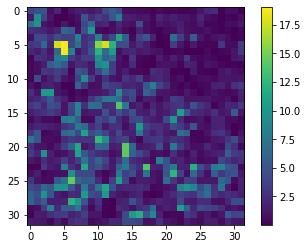

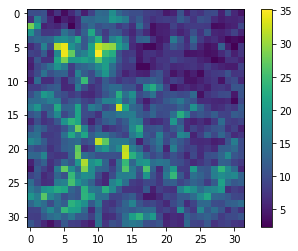

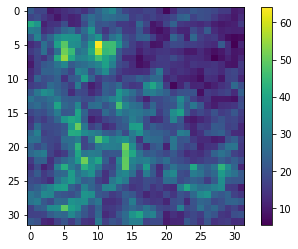

In [14]:

#check that something different is happening :P

imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

imshow(np.array(rho[2]).sum(axis=0))
colorbar()
show()


In [15]:
#benchmark pk func.. seems to be re-traced a lot? Maybe can be optimized...
%timeit k1, pkr1 = pk(rho, shape=rho[0].shape, boxsize= np.array([64,64,64]), kmin=0.1,dk=.05)


traced!


<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


traced!
traced!
traced!
traced!
traced!
traced!
traced!
13.7 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
#fiducial model
rho = sample(tf_halocat, 12.02, 0.26, 11.38, 13.31, 1.06)
k2, pkr2 = pk(rho,
         shape = rho[0].shape, 
         boxsize = np.array([32,32,32]), # WARNING: That's not the right size
         kmin=0.3,dk=.4)

Tensor("Pow:0", shape=(), dtype=float32)
(1, 19457, 3) (1, 19457)
(1, 778280, 3) (1, 778280)
traced!


<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [17]:
pkr2[0]

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.2768805 , 0.14572199, 0.09118215, 0.0641428 , 0.04614962,
       0.03195549, 0.02258277, 0.01632327, 0.00997496, 0.00648395,
       0.00465223], dtype=float32)>

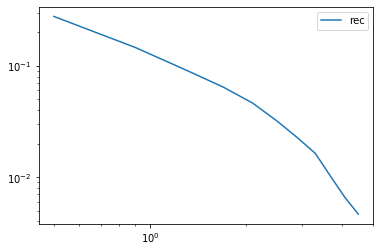

In [18]:
#loglog(k1,pkr1[0], label='data')
loglog(k2,pkr2[0], label='rec')
legend()

In [19]:
# Let's just compute a diagonal cov (takes a while...)

bs = 30
@tf.function
def get_pk(halocat):
    k2, pkr = pk(sample(tf_halocat, 12.02*np.ones(bs,dtype=float32), 0.26*np.ones(bs,dtype=float32), 11.38, 13.31*np.ones(bs,dtype=float32), 1.06*np.ones(bs,dtype=float32) ),
         shape=rho[0].shape, 
         boxsize= np.array([32,32,32]), # WARNING: That's not the right size
         kmin=0.3,dk=.2)
    print(pkr.shape)
    return pkr
import time

start_time = time.time()
samps = [get_pk(halocat) for i in range(10)]
end_time = time.time()- start_time
print(end_time)

Tensor("Pow:0", shape=(), dtype=float32)
(30, 19457, 3) (30, 19457)
(30, 778280, 3) (30, 778280)
traced!
(30, 22)
16.808948516845703


In [20]:
samps = np.stack(samps, axis=0).reshape(300,-1)
diag_std = samps.std(axis=0)
diag_std.shape

(22,)

In [21]:
covar = np.cov(samps.T,bias=False)

In [22]:
inv_covar = np.linalg.inv(covar)#/1000 
#Not currently using full covariance... is worse for some reason...

In [23]:
# Ok sweet, so now we can define these as a function of variables
logM = tf.Variable(12.5)
sig_logM = tf.Variable(0.5)
logM0 = tf.Variable(10.38)
logM1 = tf.Variable(13.01)
alpha = tf.Variable(1.6)

In [24]:
#quick example showing large sample... use this for covariance estimation? might be just as slow with the map_fn

k, pko = pk(sample(tf_halocat, tf.Variable(np.ones(10)*logM,dtype=float32), tf.Variable(sig_logM,dtype=float32), tf.Variable(logM0,dtype=float32), tf.Variable(logM1,dtype=float32), tf.Variable(alpha,dtype=float32)),shape=rho[0].shape, 
     boxsize= np.array([32,32,32]), # WARNING: That's not the right size
     kmin=0.3,dk=.4)



Tensor("Pow:0", shape=(), dtype=float32)
(10, 19457, 3) (10, 19457)
(10, 778280, 3) (10, 778280)
traced!


<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [25]:
mean_val = np.mean(np.array(pko),axis=0)
std_val = np.std(np.array(pko),axis=0)

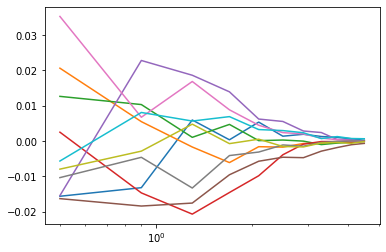

In [26]:
for pki in np.array(pko):
    plt.semilogx(k,(pki-mean_val))

In [27]:
mean_val,std_val 

(array([1.0018052 , 0.7678428 , 0.5324479 , 0.38538343, 0.27769607,
        0.17752333, 0.1136808 , 0.0680901 , 0.03800446, 0.02131485,
        0.01127904], dtype=float32),
 array([0.01668797, 0.01234686, 0.01279586, 0.00836533, 0.00489576,
        0.00299519, 0.00222796, 0.00136419, 0.00083372, 0.00053057,
        0.00031669], dtype=float32))

In [28]:
def batch_func(x,avg_samp=5):
    #for each set of parameters, we average over avg_samp runs
        _, pkr = pk(sample(tf_halocat, np.ones(avg_samp,dtype=np.float32)*x[0], np.ones(avg_samp,dtype=np.float32)*x[1], 11.38, np.ones(avg_samp,dtype=np.float32)*x[2], np.ones(avg_samp,dtype=np.float32)*x[3]),#sample(tf_halocat, X[:,0], X[:,1], 11.38, X[:,2], X[:,3]),
                 shape=rho[0].shape, 
                 boxsize= np.array([32,32,32]), # WARNING: That's not the right size
                 kmin=0.3,dk=.4)
        return tf.reduce_mean(pkr,axis=0)

In [29]:
output = batch_func(np.array([12.0,1.01,13.01, 0.20],dtype=np.float32))

Tensor("Pow:0", shape=(), dtype=float32)
(5, 19457, 3) (5, 19457)
(5, 778280, 3) (5, 778280)
traced!


<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


In [112]:
@tf.function
def loss(X):
    pkr = tf.map_fn(batch_func,X)
    return tf.reduce_mean(-1/2*((pkr - pkr2)/std_val)**2,axis=1)
   # return tf.reduce_sum(-1*(pkr - pkr2) @ (inv_covar) @ tf.transpose(pkr - pkr2),axis=1)


In [113]:
#checking loss function
X_test = tf.Variable(np.array([[12.02, 0.26, 13.31, 1.06],[13.02, 0.26, 13.31, 1.06]],dtype=float32),dtype=float32)

output = loss(X_test)

print(output)

traced!


<ipython-input-5-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


tf.Tensor([ -0.05455587 -24.71767   ], shape=(2,), dtype=float32)


In [126]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()

num_burnin_steps = int(3e2) #oops....
num_chains = 15


adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=loss,
        num_leapfrog_steps=3,
        step_size=.04), #can play a lot with this number...
    num_adaptation_steps=int(num_burnin_steps * 0.8))


In [127]:
#start spread out around some point
var = (np.random.random([num_chains, 4])-0.5)*np.array([0.1,0.02,0.1,0.01])*2.0

In [128]:

num_results = 600

# Initial state of the chain
init_state = tf.Variable(np.ones([num_chains, 4], dtype=dtype)*np.array([12.12, 0.36, 13.21, 1.16],dtype=float32)+var,dtype=float32)

@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted


In [129]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

13406.980851888657


In [130]:
#time in hours, since math is hard
print(run_time/60/60)

3.724161347746849


In [131]:
#make sure chain moved...
q[0]-q[-1]

<tf.Tensor: shape=(15, 4), dtype=float32, numpy=
array([[ 0.25891972, -0.90156657, -2.7412672 , -1.1773376 ],
       [ 0.28887844,  0.2988762 , -0.14888954,  0.15356839],
       [-0.11910248, -0.2770514 , -0.56074905,  1.0182732 ],
       [-0.42541122, -0.5115773 ,  0.60915375, -0.5215548 ],
       [ 0.48838997, -1.3633639 , -1.265523  , -1.0882441 ],
       [ 0.18513489,  0.52405566,  0.29126072,  0.4172269 ],
       [-0.41711426, -0.69657946, -1.4432802 , -0.5722294 ],
       [ 0.07215214, -0.2990008 , -1.7680416 , -4.3697033 ],
       [ 0.2674427 ,  0.85413426,  0.01005554, -0.07667446],
       [ 1.0775509 ,  1.1166501 , -2.2093134 , -1.1303376 ],
       [-0.25553513, -0.34508353, -0.71487045, -0.5950719 ],
       [-0.02489662, -0.10541725, -0.5050411 , -1.1819351 ],
       [-0.48855782, -1.2024902 , -4.4484634 , -1.1906885 ],
       [ 0.43457127,  0.08540592, -0.3564062 ,  0.12379897],
       [-1.182168  , -1.9055481 , -0.81278515, -0.3334484 ]],
      dtype=float32)>

In [132]:
loss(q[0])

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([-2.1042628 , -0.82554555, -0.7601324 , -0.7554464 , -2.2672021 ,
       -0.50867635, -2.3309093 , -1.3906242 , -0.6940007 , -1.674355  ,
       -0.6141869 , -0.5835598 , -0.7473078 , -4.2122765 , -0.27632827],
      dtype=float32)>

(array([2298., 2612., 1472.,  844.,  634.,  469.,  326.,  130.,   70.,
         145.]),
 array([11.536322 , 11.7461605, 11.955999 , 12.165839 , 12.375678 ,
        12.585517 , 12.795356 , 13.005195 , 13.2150345, 13.424873 ,
        13.634712 ], dtype=float32),
 <a list of 10 Patch objects>)

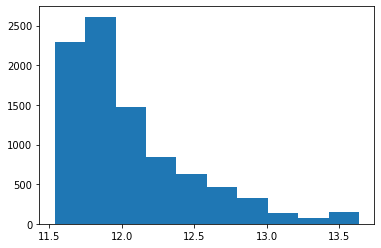

In [133]:
plt.hist(np.array(q).reshape(-1,4)[:,0])

In [134]:
import corner

In [135]:
q.shape

TensorShape([600, 15, 4])

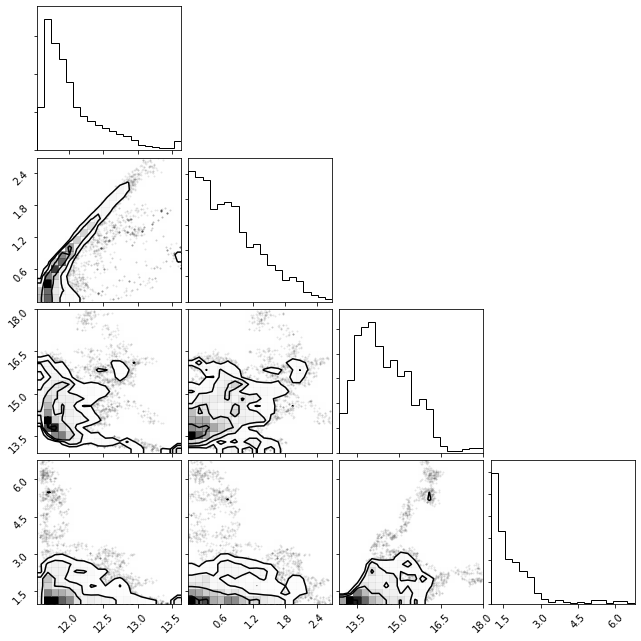

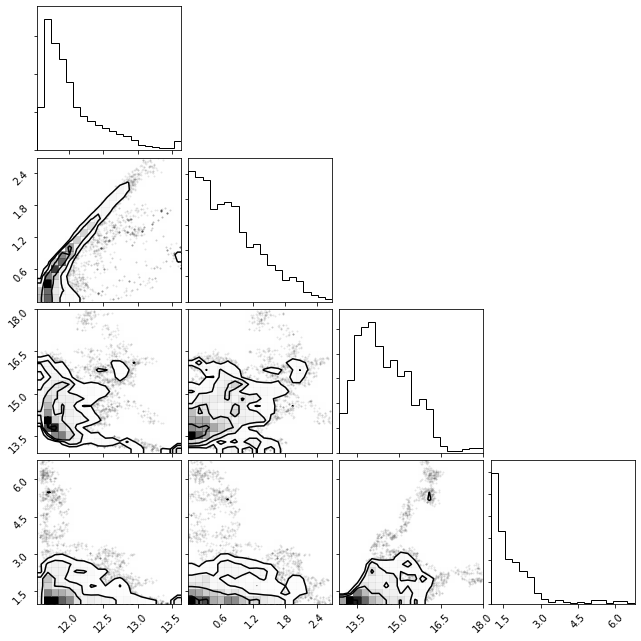

In [136]:
corner.corner(np.array(q[:,:,:]).reshape(-1,4)[:],smooth=0.300)

In [137]:
q.shape

TensorShape([600, 15, 4])

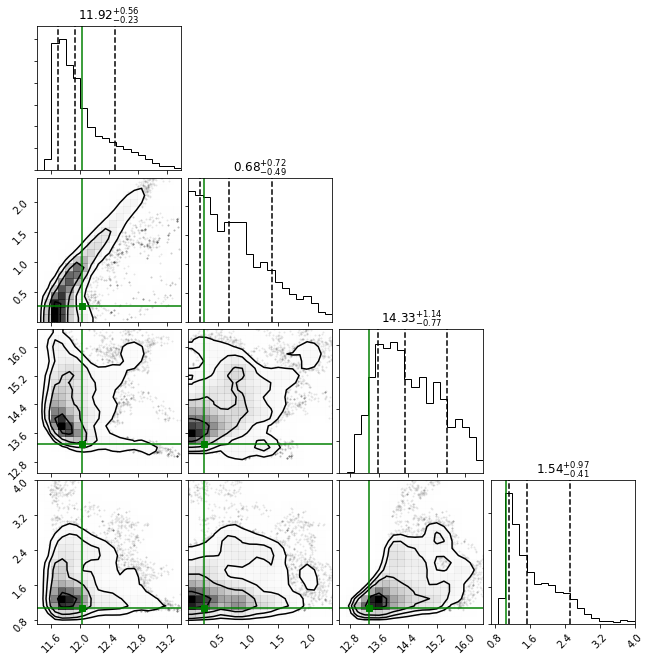

In [146]:
value1 = [12.02, 0.26, 13.31, 1.06]

figure = corner.corner(np.array(q[:]).reshape(-1,4),range=[(11.4,13.4),(0.0,2.4),(12.5,16.5),(0.7,4.0)],quantiles=[0.16, 0.5, 0.84],show_titles=True,smooth=0.80)

ndim = 4
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")


In [ ]:
#could run for longer and probably get better curves...